# Przewidywanie jakości wina - model regresji

## Opis problemu

Pozyskano dwa zbiory danych w postaci pliku csv (dla wina czerwonego i białego) ze strony:

https://archive.ics.uci.edu/dataset/186/wine+quality.

Zbiór danych posiada 11 atrybutów warunkowych oraz 
* 1599 przypadków w zbiorze wina czerwonego,
* 4898 przypadków w zbiorze wina białego.

Ostatnia kolumna reprezentuje cechę decyzyjną (ocenę jakości). Dane nie są zbalansowane (jest dużo więcej rekordów win o normalnej jakości w porównaniu do win wyśmienitych i słabych).

Celem jest znalezienie modelu regresji o najwyższej jakości i dokładności spośród rozważanych, który przewidywałby jakość wina w zalezności od zadanych parametrów.

Rozważone zostaną dwa warianty podejścia do zadania:
* w pierwszym modele trenowane będą osobno dla wina czerwonego i białego
* w wariancie 2 oba zbiory danych zostaną połączone, kolor wina będzie traktowany jako kolejny atrybut.

## Spis treści

* [Import bibliotek](#0)
* [Dane](#1)
    * [Wczytanie](#1.1)
    * [Przygotowanie](#1.2)
        * [Wariant 1](#1.2.1)
        * [Wariant 2](#1.2.2)
* [Uczenie maszynowe - model regresji](#2)
    * [Wariant 1](#2.1)
        * [Wino czerwone](#2.1.1)
        * [Wino białe](#2.1.2)
    * [Wariant 2](#2.2)
* [Wnioski](#3)

## <a name='0'></a>Import bibliotek

In [1]:
# podstawowe
import pandas as pd
import numpy as np

# wizualizacja 
import matplotlib.pyplot as plt

# transformacja danych
from sklearn import preprocessing as prep
from sklearn.preprocessing import LabelEncoder

# algorytmy UM do sprawdzenia
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

# podziel zbiór danych na trenujący i testowy
from sklearn.model_selection import train_test_split
# metryki do oceny dokładności regresji
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## <a name='1'></a>Dane

### <a name='1.1'></a>Wczytanie

In [2]:
df_rd = pd.read_csv("winequality-red.csv", sep=";")
df_rd = pd.DataFrame(df_rd)
                    
df_rd.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [3]:
# dodanie kolumny z kolorem wina 
df_rd.insert(11, "type", "red")

df_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  type                  1599 non-null   object 
 12  quality               1599 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB


In [4]:
df_wh = pd.read_csv("winequality-white.csv", sep=";")
df_wh = pd.DataFrame(df_wh)
                    
df_wh.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [5]:
# dodanie kolumny z kolorem wina 
df_wh.insert(11, "type", "white")

df_wh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  type                  4898 non-null   object 
 12  quality               4898 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 497.6+ KB


In [6]:
# lista nazw column
atrybuty = list(df_rd.columns)

atrybuty

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'type',
 'quality']

In [7]:
# przejście z dataframe na tablice
data_rd = df_rd.to_numpy()
data_wh = df_wh.to_numpy()

print(f"Dane dot. wina czerwonego: \n{data_rd}")
print(f"\nDane dot. wina białego: \n{data_wh}")

Dane dot. wina czerwonego: 
[[7.4 0.7 0.0 ... 9.4 'red' 5]
 [7.8 0.88 0.0 ... 9.8 'red' 5]
 [7.8 0.76 0.04 ... 9.8 'red' 5]
 ...
 [6.3 0.51 0.13 ... 11.0 'red' 6]
 [5.9 0.645 0.12 ... 10.2 'red' 5]
 [6.0 0.31 0.47 ... 11.0 'red' 6]]

Dane dot. wina białego: 
[[7.0 0.27 0.36 ... 8.8 'white' 6]
 [6.3 0.3 0.34 ... 9.5 'white' 6]
 [8.1 0.28 0.4 ... 10.1 'white' 6]
 ...
 [6.5 0.24 0.19 ... 9.4 'white' 6]
 [5.5 0.29 0.3 ... 12.8 'white' 7]
 [6.0 0.21 0.38 ... 11.8 'white' 6]]


### <a name='1.2'></a>Przygotowanie

#### <a name='1.2.1'></a>Wariant 1 - trenujemy modele osobno dla wina czerwonego i białego

Pominięto aspekt koloru wina. Nie ma konieczności kodowania, ponieważ wszytskie pozostałe atrybuty nie są wyrażone zmienną dyskretną.

In [8]:
# wino czerwone
X_rd = data_rd[:,:-2]  # atrybuty bez "type"
y_rd = data_rd[:,-1]  # decyzja

# wino białe
X_wh = data_wh[:,:-2]  # atrybuty bez "type"
y_wh = data_wh[:,-1]  # decyzja

#### <a name='1.2.2'></a>Wariant 2 -  trenujemy model dla wszystkich rekordów łącznie

Kolor wina potraktowano jako jeden z atrybutów, który współwpływa na jakość w kombinacji z pozostałymi cechami.

In [9]:
X_rd2 = data_rd[:,:-1]  # atrybuty
y_rd2 = data_rd[:,-1]  # decyzja

X_wh2 = data_wh[:,:-1]  # atrybuty
y_wh2 = data_wh[:,-1]  # decyzja

X = np.concatenate((X_rd2, X_wh2), axis=0)
y = np.concatenate((y_rd2, y_wh2), axis=0)

# transformacja danych
le = LabelEncoder()
le.fit(["red", "white"])  # red: 0, white: 1
list(le.classes_)

X[:,-1] = le.fit_transform(X[:,-1])

X  # podgląd

array([[7.4, 0.7, 0.0, ..., 0.56, 9.4, 0],
       [7.8, 0.88, 0.0, ..., 0.68, 9.8, 0],
       [7.8, 0.76, 0.04, ..., 0.65, 9.8, 0],
       ...,
       [6.5, 0.24, 0.19, ..., 0.46, 9.4, 1],
       [5.5, 0.29, 0.3, ..., 0.38, 12.8, 1],
       [6.0, 0.21, 0.38, ..., 0.32, 11.8, 1]], dtype=object)

In [10]:
# sprawdzenie, czy kodowanie przebiegło poprawnie
red = 0
white = 0

for i in range(len(X)):
  if X[i][-1] == 0:
    red += 1
  else:
    white +=1
    
print(red)
print(white)

1599
4898


Kodowanie przebiegło poprawnie. Liczba "red" oraz "white" zgodna z ilością rekordów w odpowiadających zbiorach danych.

## <a name='2'></a>Uczenie maszynowe - model regresji

In [11]:
# algorytmy UM do sprawdzenia
regressors = {
    "LR"      : LinearRegression(),
    
    "DT2"     : DecisionTreeRegressor(max_depth=2),
    "DT5"     : DecisionTreeRegressor(max_depth=5),
    "DT10"    : DecisionTreeRegressor(max_depth=10),
    "DT"     : DecisionTreeRegressor(max_depth=None, random_state=1),

    "knn5"    : KNeighborsRegressor(n_neighbors=5),
    "knn10"   : KNeighborsRegressor(n_neighbors=10),
    "knn50"   : KNeighborsRegressor(n_neighbors=50),
    "knn100"  : KNeighborsRegressor(n_neighbors=100),

    "RF100.1" : RandomForestRegressor(n_estimators = 100, random_state=1),
    "RF100.2" : RandomForestRegressor(n_estimators = 100, random_state=2),
    "RF250.1" : RandomForestRegressor(n_estimators = 250, random_state=1),
    "RF250.2" : RandomForestRegressor(n_estimators = 250, random_state=2),
    "RF500.1" : RandomForestRegressor(n_estimators = 500, random_state=1),
    "RF500.2" : RandomForestRegressor(n_estimators = 500, random_state=2),
    
    "GBR.1.10.1" : GradientBoostingRegressor(n_estimators=10, random_state=1, learning_rate=0.01),
    "GBR.1.100"  : GradientBoostingRegressor(n_estimators=100, random_state=1, learning_rate=0.1),
    "GBR.2.100"  : GradientBoostingRegressor(n_estimators=100, random_state=1, learning_rate=0.2),
    "GBR.1.500"  : GradientBoostingRegressor(n_estimators=500, random_state=1, learning_rate=0.1),
    "GBR.2.500"  : GradientBoostingRegressor(n_estimators=500, random_state=1, learning_rate=0.2)
}

*Metryki do oceny dokładności regresji:*
* **Mean Absolute Error (MAE)**: im niższa wartość, tym lepsze modele.
* **Mean Squared Error (MSE)**: im niższa wartość, tym lepsze modele.
* **Root Mean Squared Error (RMSE)**: im niższa wartość, tym lepsze modele.

*Metryki do oceny jakości modelu:*
* **R-squared (R2) score**: im wyższa wartość, tym lepsze modele.

In [12]:
# dla zbioru danych ocen metryki
col = ['MSE', 'RMSE', 'MAE', 'R2']
index = regressors

### <a name='2.1'></a>Wariant 1

#### <a name='2.1.1'></a>Wino czerwone

In [13]:
# nowy zestaw danych
new_data_w1 = [
    [6.2, 0.32, 0.33, 18.5, 0.051, 25.0, 144.0, 0.9955, 3.13, 0.47, 9.9],
    [7.6, 0.25, 0.41, 5.5, 0.040, 11.1, 98.0, 1.0005, 3.00, 0.42, 8.8]
]

In [16]:
# podziel zbiór danych na trenujący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_rd, y_rd, test_size=0.3)

# ocena regresorów
best_r2_w1rd = ("brak", 0)  # model o najwyższej jakości -- r2
best_rmse_w1rd = ("brak", 1)  # model o najwyższej dokładności pod względem RMSE

# df oceny regresorów
df_w1rd = pd.DataFrame(data={}, index=index, columns=col)

for reg_name in regressors:
    reg = regressors[reg_name]

    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # ocena jakości --- max r2
    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2_w1rd[1]:
      best_r2_w1rd = (reg_name, r2)

    # ocena dokładności --- min rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    if rmse < best_rmse_w1rd[1]:
      best_rmse_w1rd = (reg_name, rmse)
    
    # zawrzyj w df oceny regresorów
    df_w1rd.loc[reg_name] = [MSE, RMSE, MAE, R2]

df_w1rd

,MSE,RMSE,MAE,R2
LR,0.406565,0.637624,0.494714,0.349817
DT2,0.480426,0.693127,0.550699,0.231698
DT5,0.459929,0.678181,0.532565,0.264476
DT10,0.553394,0.743905,0.51487,0.115005
DT,0.629167,0.7932,0.479167,-0.006171
knn5,0.565833,0.752219,0.573333,0.095113
knn10,0.541875,0.736122,0.579167,0.133427
knn50,0.574895,0.758218,0.605333,0.080621
knn100,0.586649,0.76593,0.626833,0.061824
RF100.1,0.327583,0.572348,0.418042,0.476126



Najwyższa jakość:         RF250.1 	 r2 =  0.48757857223174683

Ok. 48.76% zmienności jakości wina zostało wyjaśnione przez model.

Najwyższa dokładność:     RF250.1 	 rmse =  0.566057682573075

Wartości przewidywane wahają się przeciętnie od wartości rzeczywistych o 0.57 punktu oceny.



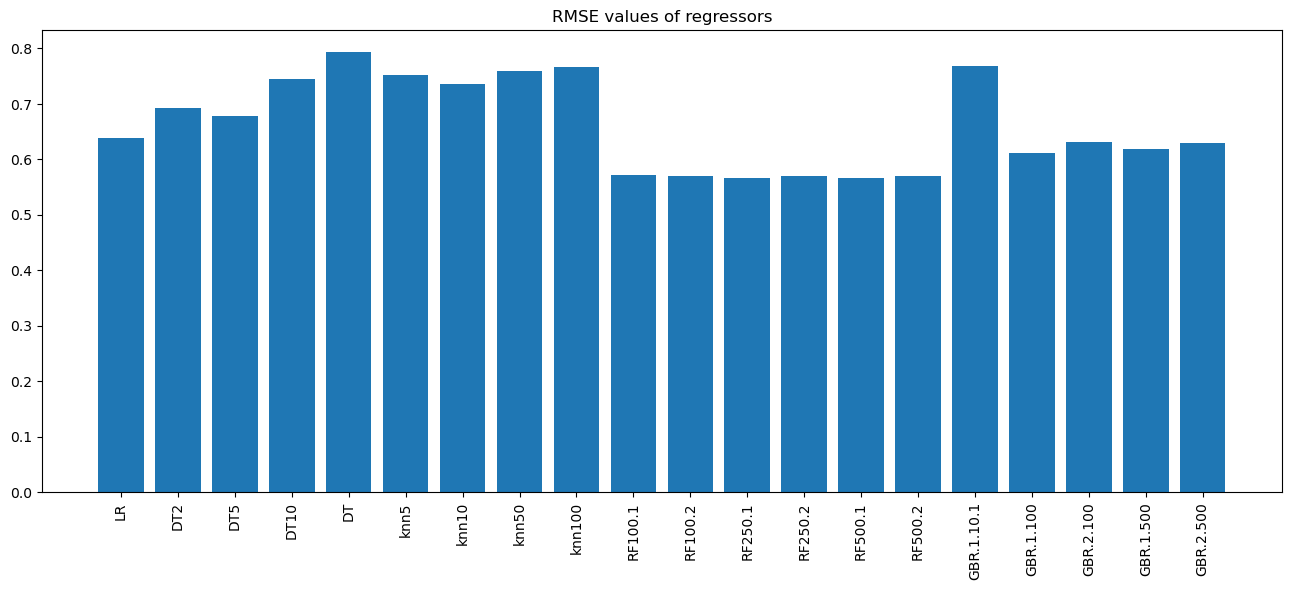

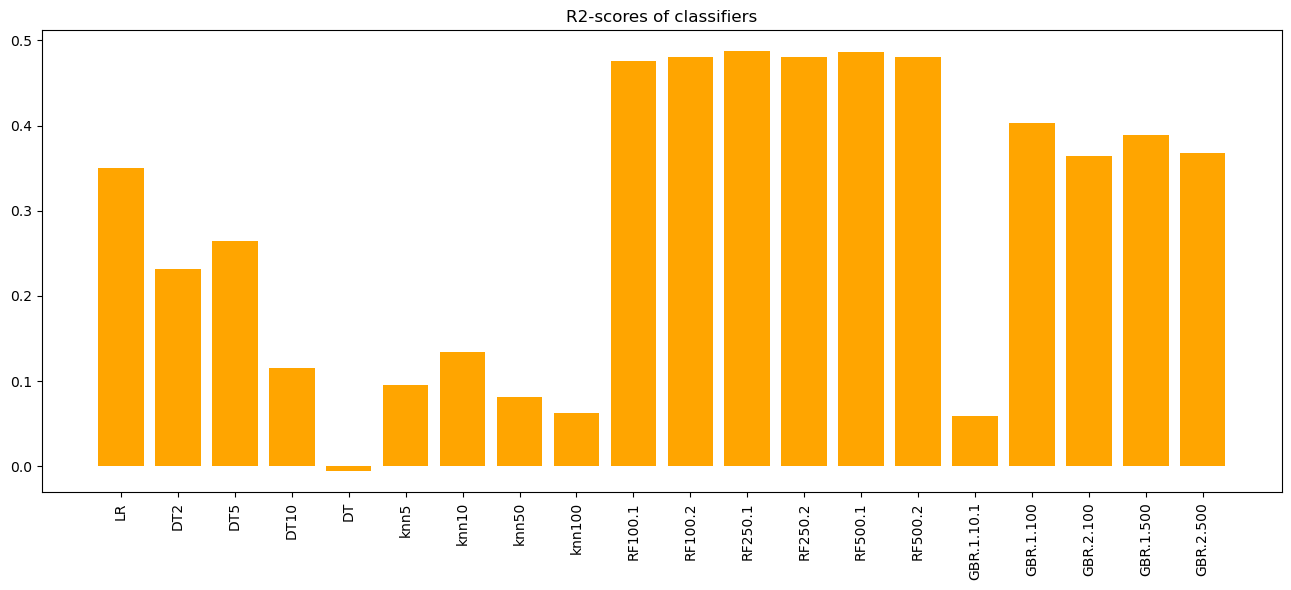

In [17]:
# zmień index df na listę
index_array_w1rd = np.array(df_w1rd.index.tolist()) 

# wykres słupkowy wartości błędu RMSE dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w1rd, height = 'RMSE', data = df_w1rd, align = 'center')
plt.title('RMSE values of regressors')
plt.gca().tick_params(axis='x', rotation=90)

# wykres słupkowy wartości R2 dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w1rd, height = 'R2', data = df_w1rd, align = 'center', color='orange')
plt.title('R2-scores of classifiers')
plt.gca().tick_params(axis='x', rotation=90)

# wnioski
print("\nNajwyższa jakość:        ", best_r2_w1rd[0],    "\t r2 = ", best_r2_w1rd[1])
print("\nOk. {}% zmienności jakości wina zostało wyjaśnione przez model.".format((best_r2_w1rd[1]*100).round(2)))
print("\nNajwyższa dokładność:    ", best_rmse_w1rd[0],  "\t rmse = ", best_rmse_w1rd[1])
print("\nWartości przewidywane wahają się przeciętnie od wartości rzeczywistych o {} punktu oceny.\n".format(best_rmse_w1rd[1].round(2)))

In [18]:
best_reg_w1rd = regressors[best_r2_w1rd[0]]

best_reg_w1rd.fit(X_rd, y_rd)  # trenuj na wszystkim

result_rd = best_reg_w1rd.predict(new_data_w1)

result_rd  # podgląd

array([5.456, 5.116])

#### <a name='2.1.2'></a>Wino białe

In [20]:
# podziel zbiór danych na trenujący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_wh, y_wh, test_size=0.3)

# ocena regresorów
best_r2_w1wh = ("brak", 0)  # model o najwyższej jakości -- r2
best_rmse_w1wh = ("brak", 1)  # model o najwyższej dokładności pod względem RMSE

# df oceny regresorów
df_w1wh = pd.DataFrame(data={}, index=index, columns=col)

for reg_name in regressors:
    reg = regressors[reg_name]

    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # ocena jakości --- max r2
    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2_w1wh[1]:
      best_r2_w1wh = (reg_name, r2)

    # ocena dokładności --- min rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    if rmse < best_rmse_w1wh[1]:
      best_rmse_w1wh = (reg_name, rmse)
    
    # zawrzyj w df oceny regresorów
    df_w1wh.loc[reg_name] = [MSE, RMSE, MAE, R2]

df_w1wh

,MSE,RMSE,MAE,R2
LR,0.577691,0.76006,0.588815,0.265846
DT2,0.616474,0.785159,0.633679,0.216559
DT5,0.582881,0.763467,0.604239,0.25925
DT10,0.637609,0.798504,0.58486,0.1897
DT,0.797959,0.893286,0.539456,-0.01408
knn5,0.648653,0.80539,0.628027,0.175665
knn10,0.630231,0.793871,0.632109,0.199076
knn50,0.650544,0.806563,0.635469,0.173261
knn100,0.664136,0.814946,0.642395,0.155988
RF100.1,0.38923,0.623883,0.456469,0.505351



Najwyższa jakość:         RF500.2 	 r2 =  0.5073326454199059

Ok. 50.73% zmienności jakości wina zostało wyjaśnione przez model.

Najwyższa dokładność:     RF500.2 	 rmse =  0.6226315843224774

Wartości przewidywane wahają się przeciętnie od wartości rzeczywistych o 0.62 punktu oceny.



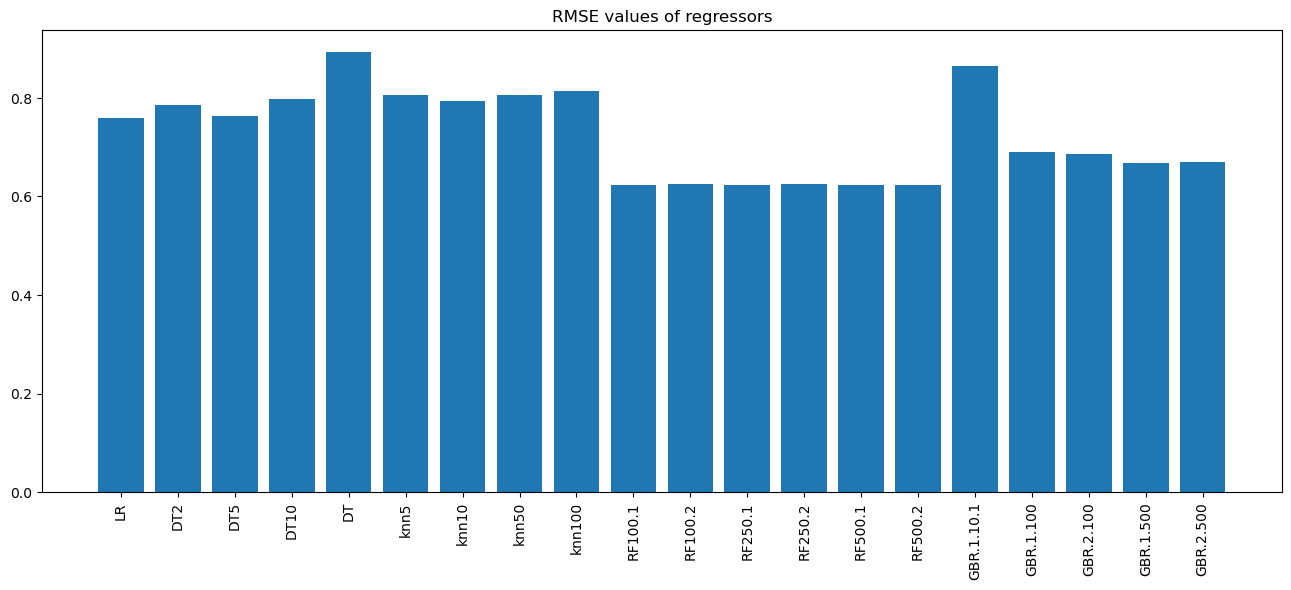

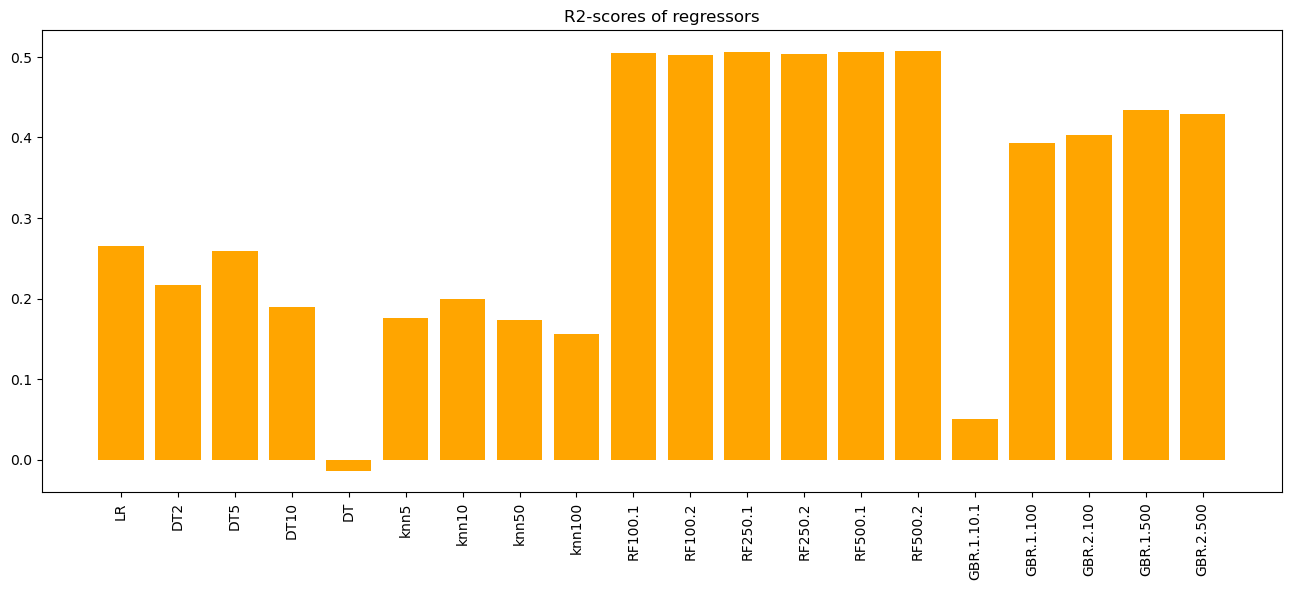

In [21]:
# zmień index df na listę
index_array_w1wh = np.array(df_w1wh.index.tolist()) 

# wykres słupkowy wartości błędu RMSE dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w1wh, height = 'RMSE', data = df_w1wh, align = 'center')
plt.title('RMSE values of regressors')
plt.gca().tick_params(axis='x', rotation=90)

# wykres słupkowy wartości R2 dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w1wh, height = 'R2', data = df_w1wh, align = 'center', color='orange')
plt.title('R2-scores of regressors')
plt.gca().tick_params(axis='x', rotation=90)

# wnioski
print("\nNajwyższa jakość:        ", best_r2_w1wh[0],    "\t r2 = ", best_r2_w1wh[1])
print("\nOk. {}% zmienności jakości wina zostało wyjaśnione przez model.".format((best_r2_w1wh[1]*100).round(2)))
print("\nNajwyższa dokładność:    ", best_rmse_w1wh[0],  "\t rmse = ", best_rmse_w1wh[1])
print("\nWartości przewidywane wahają się przeciętnie od wartości rzeczywistych o {} punktu oceny.\n".format((best_rmse_w1wh[1]).round(2)))

In [22]:
best_reg_w1wh = regressors[best_r2_w1wh[0]]

best_reg_w1wh.fit(X_wh, y_wh)  # trenuj na wszystkim

result_wh = best_reg_w1wh.predict(new_data_w1)

result_wh  # podgląd

array([5.454, 5.252])

### <a name='2.2'></a>Wariant 2

In [23]:
# nowy zestaw danych
new_data_w2 = [
    [6.2, 0.32, 0.33, 18.5, 0.051, 25.0, 144.0, 0.9955, 3.13, 0.47, 9.9, 1],
    [7.6, 0.25, 0.41, 5.5, 0.040, 11.1, 98.0, 1.0005, 3.00, 0.42, 8.8, 0]
]

In [24]:
# podziel zbiór danych na trenujący i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# ocena regresorów
best_r2_w2 = ("brak", 0)  # model o najwyższej jakości -- r2
best_rmse_w2 = ("brak", 1)  # model o najwyższej dokładności pod względem RMSE

# df oceny regresorów
df_w2 = pd.DataFrame(data={}, index=index, columns=col)

for reg_name in regressors:
    reg = regressors[reg_name]

    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # ocena jakości --- max r2
    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2_w2[1]:
      best_r2_w2 = (reg_name, r2)

    # ocena dokładności --- min rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    if rmse < best_rmse_w2[1]:
      best_rmse_w2 = (reg_name, rmse)
    
    # zawrzyj w df oceny regresorów
    df_w2.loc[reg_name] = [MSE, RMSE, MAE, R2]

df_w2

,MSE,RMSE,MAE,R2
LR,0.541086,0.735585,0.567454,0.295195
DT2,0.59291,0.770007,0.607157,0.227689
DT5,0.541209,0.735669,0.578323,0.295034
DT10,0.549625,0.741367,0.545061,0.284072
DT,0.672308,0.819944,0.481538,0.124268
knn5,0.653477,0.808379,0.629641,0.148797
knn10,0.638077,0.798797,0.634615,0.168856
knn50,0.667938,0.817275,0.652379,0.12996
knn100,0.687156,0.828949,0.6648,0.104927
RF100.1,0.372824,0.610593,0.439303,0.514368



Najwyższa jakość:         RF250.1 	 r2 =  0.5179838038706283

Ok. 51.8% zmienności jakości wina zostało wyjaśnione przez model.

Najwyższa dokładność:     RF250.1 	 rmse =  0.6083161121552612

Wartości przewidywane wahają się przeciętnie od wartości rzeczywistych o 0.61 punktu oceny.



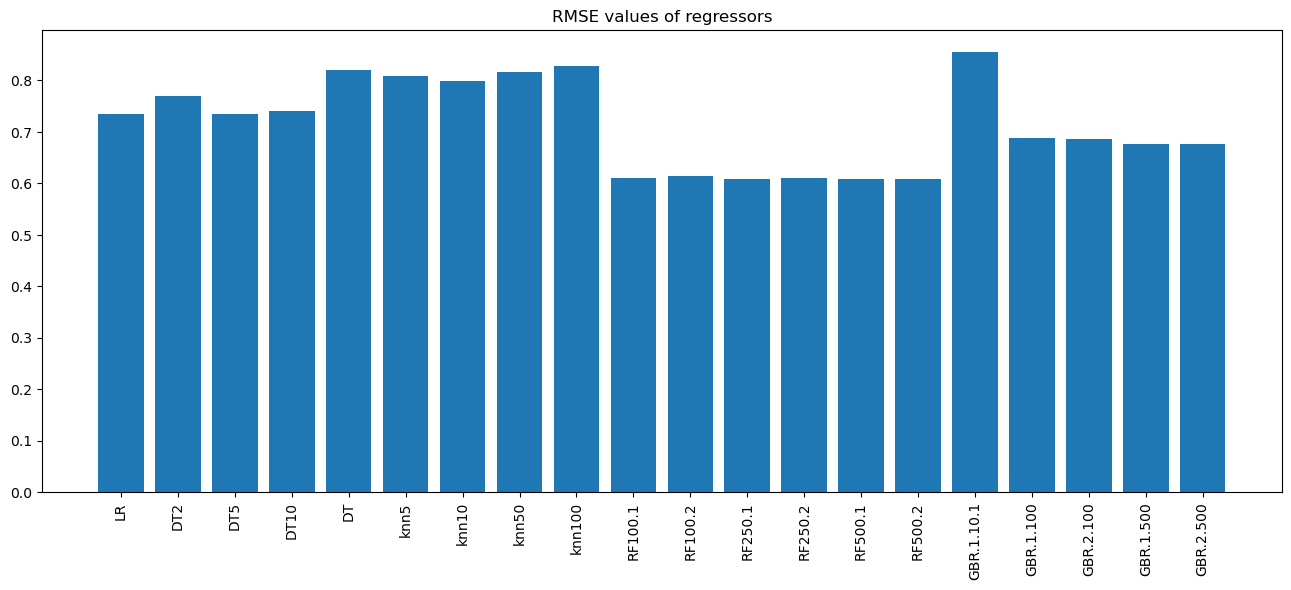

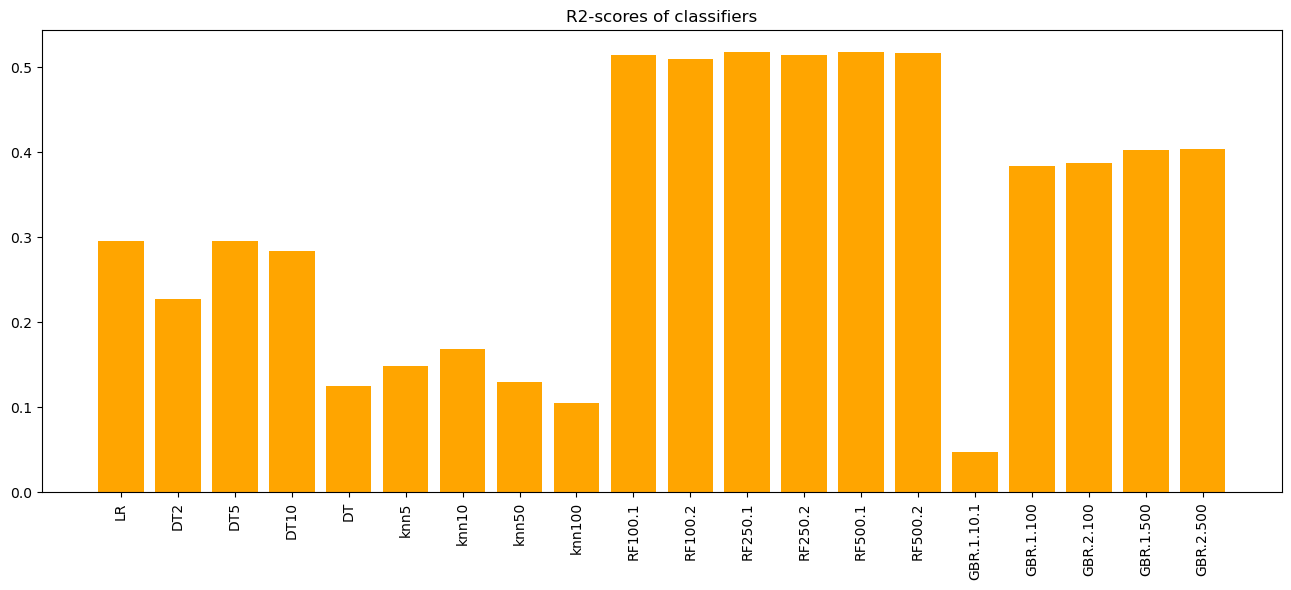

In [25]:
# zmień index df na listę
index_array_w2 = np.array(df_w2.index.tolist()) 

# wykres słupkowy wartości błędu RMSE dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w2, height = 'RMSE', data = df_w2, align = 'center')
plt.title('RMSE values of regressors')
plt.gca().tick_params(axis='x', rotation=90)

# wykres słupkowy wartości R2 dla regresorów
plt.figure(figsize=(16,6))
plt.bar(x = index_array_w2, height = 'R2', data = df_w2, align = 'center', color='orange')
plt.title('R2-scores of classifiers')
plt.gca().tick_params(axis='x', rotation=90)

# wnioski
print("\nNajwyższa jakość:        ", best_r2_w2[0],    "\t r2 = ", best_r2_w2[1])
print("\nOk. {}% zmienności jakości wina zostało wyjaśnione przez model.".format((best_r2_w2[1]*100).round(2)))
print("\nNajwyższa dokładność:    ", best_rmse_w2[0],  "\t rmse = ", best_rmse_w2[1])
print("\nWartości przewidywane wahają się przeciętnie od wartości rzeczywistych o {} punktu oceny.\n".format(best_rmse_w2[1].round(2)))

In [27]:
best_reg_w2 = regressors[best_r2_w2[0]]

best_reg_w2.fit(X,y)  # trenuj na wszystkim

result = best_reg_w2.predict(new_data_w2)

result  # podgląd

array([5.472, 5.536])

## <a name='3'></a>Wnioski

We wszystkich analizowanych wariantach grupa klasyfikatorów z *RandomForestRegressor* charakteryzowała się najniższym błędem RMSE i najwyższym wskaźnikiem R2, tym samym ocenia się ją jako najlepszą spośród analizowanych klasyfikatorów zarówno pod względem jakości jak i dokładności. Zmiana parametrów wewnętrznych nie wpływała istotnie na jakość wyniku.